In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt

from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install statsmodels
!pip install pystan~=2.14
!pip install fbprophet

In [ ]:
df = pd.read_parquet('2020-2022_history_data_processed.parquet.brotli')
df.head()

,Station,City,State,Date,Time,PM25,PM10,CO,NO2,NH3,O3,SO2,AQI,AQI_bucket
0,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,10:00:00,32.76,37.19,0.57,6.28,11.40,130.18,12.88,176.0,Moderate
1,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,11:00:00,43.00,50.81,0.82,13.66,19.00,97.28,15.50,176.0,Moderate
2,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,12:00:00,51.04,61.88,1.04,22.77,25.08,63.66,17.17,176.0,Moderate
3,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,13:00:00,55.24,68.78,1.12,26.22,29.64,42.20,16.69,176.0,Moderate
4,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,14:00:00,58.45,73.32,1.12,24.04,29.89,33.98,15.26,176.0,Moderate


In [ ]:
tempdf = df.groupby(['City','Date']).mean().reset_index()
tempdf.head()

,City,Date,PM25,PM10,CO,NO2,NH3,O3,SO2,AQI
0,Agartala,2020-11-28,104.606429,124.784286,1.040000,14.719286,10.559286,43.337143,1.912857,245.642857
1,Agartala,2020-11-29,97.869167,115.230833,0.973750,11.354583,16.983750,62.903750,2.817083,252.041667
2,Agartala,2020-11-30,126.995417,147.259583,1.184583,17.886250,14.861667,60.678750,4.024167,274.833333
3,Agartala,2020-12-01,120.864167,140.599167,0.992917,11.260417,10.057083,67.114167,4.995000,294.750000
4,Agartala,2020-12-02,139.565833,164.991667,1.170417,12.983750,13.930417,58.895417,5.323750,312.708333


In [ ]:
delhi = tempdf.loc[tempdf['City']=='Delhi']
chennai = tempdf.loc[tempdf['City']=='Chennai']
mumbai = tempdf.loc[tempdf['City']=='Mumbai']
hyderabad = tempdf.loc[tempdf['City']=='Hyderabad']
bengaluru = tempdf.loc[tempdf['City']=='Bengaluru']

delhi = delhi[['Date','AQI']]
chennai = chennai[['Date','AQI']]
mumbai = mumbai[['Date','AQI']]
hyderabad = hyderabad[['Date','AQI']]
bengaluru = bengaluru[['Date','AQI']]

delhi['AQI'] = delhi['AQI'].astype(int)
chennai['AQI'] = chennai['AQI'].astype(int)
mumbai['AQI'] = mumbai['AQI'].astype(int)
hyderabad['AQI'] = hyderabad['AQI'].astype(int)
bengaluru['AQI'] = bengaluru['AQI'].astype(int)

delhi.reset_index(level=0,inplace=True,drop=True)
chennai.reset_index(level=0,inplace=True,drop=True)
mumbai.reset_index(level=0,inplace=True,drop=True)
hyderabad.reset_index(level=0,inplace=True,drop=True)
bengaluru.reset_index(level=0,inplace=True,drop=True)

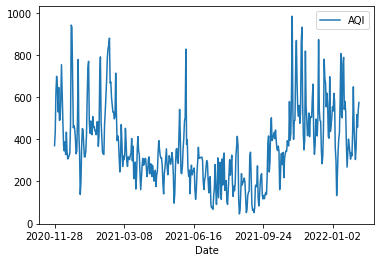

In [ ]:
delhi.plot.line(x="Date", y="AQI")
plt.show()

### Holt

In [ ]:
y = delhi["AQI"]
y_train = delhi["AQI"][:399]
y_test = delhi["AQI"][399:]

In [ ]:
span = 3

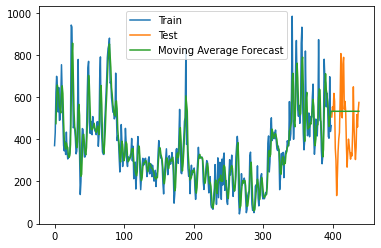

166.38802541048437


In [ ]:
fcast = y_train.rolling(span).mean()
MA = fcast.iloc[-1]
MA_series = pd.Series(MA.repeat(len(y_test)))
MA_fcast = pd.concat([fcast, MA_series], ignore_index=True)
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(MA_fcast, label="Moving Average Forecast")
plt.legend(loc="best")
plt.show()
rms = sqrt(mean_squared_error(y_test, MA_series))
print(rms)

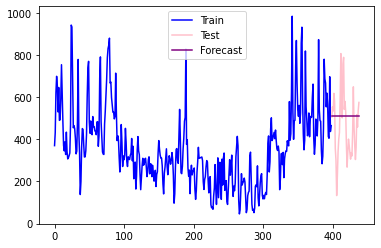

157.11838633955512


In [ ]:
alpha = 0.25
# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(y_train).fit(smoothing_level=alpha)
fcast1 = fit1.forecast(len(y_test)).rename(r"$\alpha=0.1$")
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast1.plot(color="purple", label="Forecast")
plt.legend(loc="best")
plt.show()
rms = sqrt(mean_squared_error(y_test, fcast1))
print(rms)

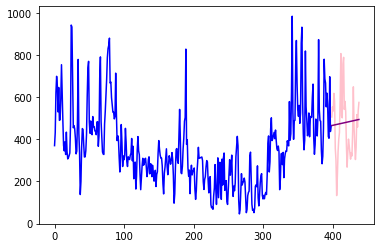

151.0208971668189


In [ ]:
# Holt's Method
alpha = 0.9
beta = 0.01
### Linear Trend
fit1 = Holt(y_train).fit(smoothing_level=alpha,smoothing_slope=beta)
fcast1 = fit1.forecast(len(y_test)).rename("Holt's linear trend")
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast1.plot(color="purple", label="Forecast")
plt.show()
rms = sqrt(mean_squared_error(y_test, fcast1))
print(rms)

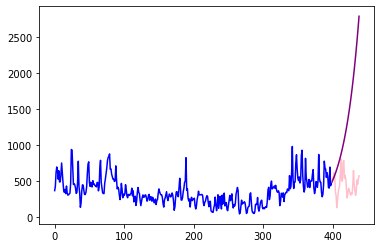

1116.6360320435272


In [ ]:
### Exponential Trend
fit2 = Holt(y_train, exponential=True).fit(smoothing_level=0.9, smoothing_slope=0.01)
fcast2 = fit2.forecast(len(y_test)).rename("Exponential trend")

# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast2.plot(color="purple", label="Forecast")
plt.show()
rms = sqrt(mean_squared_error(y_test, fcast2))
print(rms)


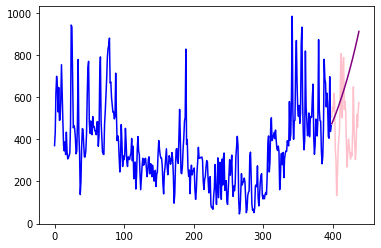

295.0710430065462


In [ ]:
### Exponential Trend
fit2 = Holt(y_train, exponential=True).fit(smoothing_level=0.9, smoothing_slope=0.2)
fcast2 = fit2.forecast(len(y_test)).rename("Exponential trend")

# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast2.plot(color="purple", label="Forecast")
plt.show()
rms = sqrt(mean_squared_error(y_test, fcast2))
print(rms)


148.55843867572543


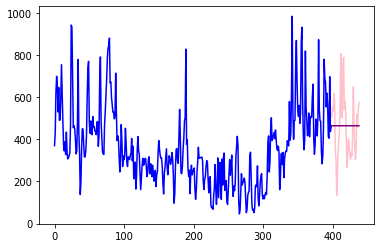

In [ ]:
### Additive Damped Trend
fit3 = Holt(y_train, damped=True).fit(smoothing_level=0.9, smoothing_slope=0.2)
fcast3 = fit3.forecast(len(y_test)).rename("Additive damped trend")

# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast3.plot(color="purple", label="Forecast")
rms = sqrt(mean_squared_error(y_test, fcast3))
print(rms)


148.56493424481857


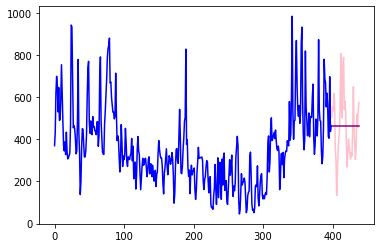

In [ ]:
### Multiplicative Damped Trend
fit3 = Holt(y_train, exponential=True, damped=True).fit(
    smoothing_level=0.9, smoothing_slope=0.1
)
fcast3 = fit3.forecast(len(y_test)).rename("Multiplicative damped trend")

# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast3.plot(color="purple", label="Forecast")
rms = sqrt(mean_squared_error(y_test, fcast3))
print(rms)


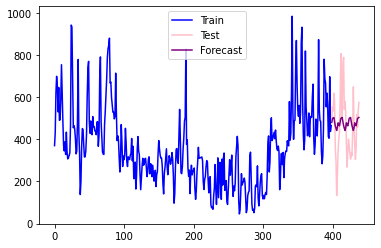

146.29243459626724


In [ ]:
########### Additive #####################
fit1 = ExponentialSmoothing(
    y_train, seasonal_periods=12, trend="add", seasonal="add"
).fit()

fcast1 = fit1.forecast(len(y_test)).rename(
    "Holt-Winters Additive Trend and seasonality"
)
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast1.plot(color="purple", label="Forecast")
plt.legend(loc="best")
plt.show()
rms = sqrt(mean_squared_error(y_test, fcast1))
print(rms)

157.07448560081863


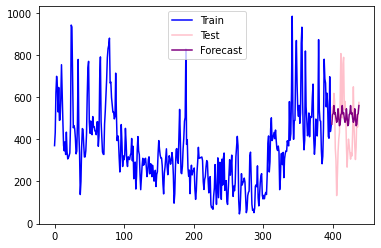

In [ ]:
########### Multiplicative #####################
fit2 = ExponentialSmoothing(
    y_train, seasonal_periods=12, trend="add", seasonal="mul"
).fit()

fcast2 = fit2.forecast(len(y_test)).rename(
    "Holt-Winters Additive Trend and Multiplicative seasonality"
)
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast2.plot(color="purple", label="Forecast")
plt.legend(loc="best")
rms = sqrt(mean_squared_error(y_test, fcast2))
print(rms)

145.83928477016752


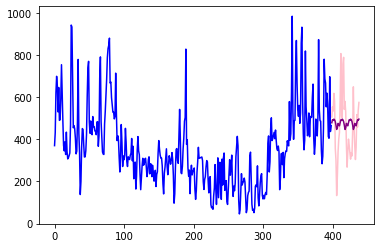

In [ ]:
########### Seasonal Additive & Damped #####################
fit3 = ExponentialSmoothing(
    y_train, seasonal_periods=12, trend="add", seasonal="add", damped=True
).fit()

fcast3 = fit3.forecast(len(y_test)).rename(
    "Holt-Winters Additive Trend and seasonality with damping"
)
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast3.plot(color="purple", label="Forecast")
rms = sqrt(mean_squared_error(y_test, fcast3))
print(rms)


157.06393546401108


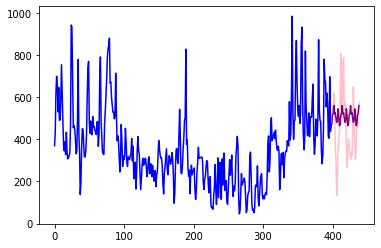

In [ ]:
########### Seasonal Multiplicative & Damped #####################
fit4 = ExponentialSmoothing(
    y_train, seasonal_periods=12, trend="add", seasonal="mul", damped=True
).fit()

fcast4 = fit4.forecast(len(y_test)).rename(
    "Holt-Winters Multiplicative Trend and Multiplicative seasonality with damping"
)
# plot
y_train.plot(color="blue", label="Train")
y_test.plot(color="pink", label="Test")
fcast4.plot(color="purple", label="Forecast")

rms = sqrt(mean_squared_error(y_test, fcast4))
print(rms)
